In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [4]:
# Chargement des données
df = pd.read_csv('personal_expense_classification.csv')
df = df.dropna()  # Supprimer les lignes vides

# Vérification des colonnes
print(df.columns)

# Encodage des catégories
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['category'])
num_classes = len(label_encoder.classes_)

# Séparation en train/test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['description'], df['category_encoded'], test_size=0.2, random_state=42
)

# TextVectorization
max_features = 10000
sequence_length = 50

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

# Adapter la couche au vocabulaire
vectorize_layer.adapt(train_texts.values)


Index(['expense_id', 'amount', 'merchant', 'description', 'category'], dtype='object')


In [5]:
embedding_dim = 128

model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),  # Entrée = texte brut
    vectorize_layer,
    layers.Embedding(input_dim=max_features + 1, output_dim=embedding_dim),
    layers.Bidirectional(layers.LSTM(64)),  # Lecture bidirectionnelle
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Classification multi-classe
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 128)        │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,387,525 (5.29 MB)

 Trainable params: 1,387,525 (5.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np

# Callbacks
nlp_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_nlp.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

nlp_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Compilation du modèle
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Entraînement
epochs = 10

# Conversion en tf.Tensor avec le bon type
train_texts = tf.constant(train_texts.tolist(), dtype=tf.string)
test_texts = tf.constant(test_texts.tolist(), dtype=tf.string)

history = model.fit(
    train_texts,
    train_labels,
    validation_data=(test_texts, test_labels),
    epochs=epochs,
    callbacks=[nlp_checkpoint_callback, nlp_early_stopping_callback]
)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.1680 - loss: 1.6105 - val_accuracy: 0.3500 - val_loss: 1.6013
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3781 - loss: 1.5772 - val_accuracy: 0.3500 - val_loss: 1.6007
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2242 - loss: 1.5569 - val_accuracy: 0.3500 - val_loss: 1.6065
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2859 - loss: 1.5448 - val_accuracy: 0.3500 - val_loss: 1.6204
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3125 - loss: 1.5404 - val_accuracy: 0.3500 - val_loss: 1.6438


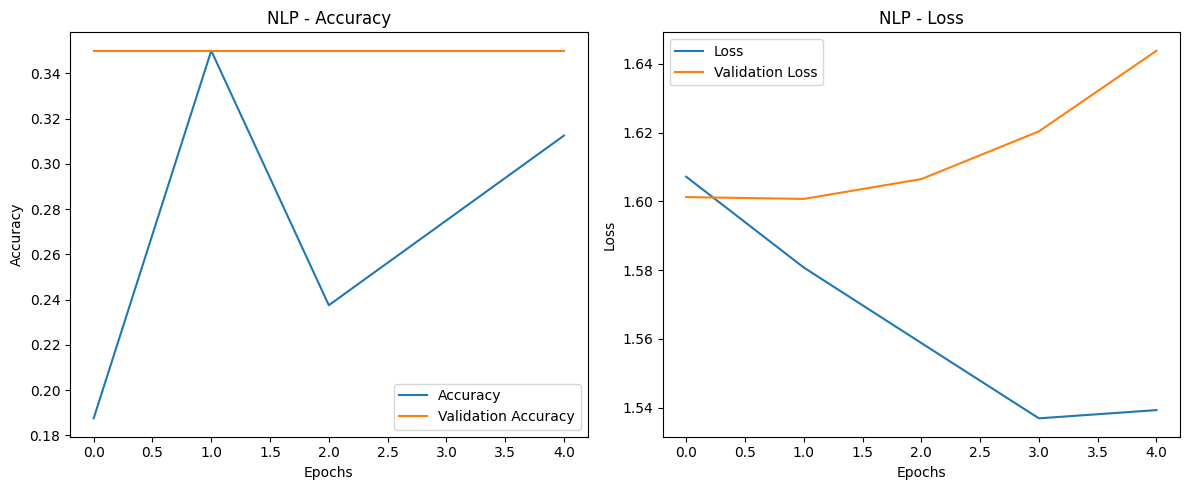

In [13]:
import matplotlib.pyplot as plt

# Courbes de précision
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('NLP - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Courbes de perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('NLP - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

